In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt

## Generate dataset
- y = x^3 + e, e ~ N(0, 3^2)

In [2]:
np.random.seed(7)
sig = 3

n = 20
x_data = 8 * np.random.random(size=n) - 4
e = sig * np.random.randn(n)

yfun = lambda x: x**3 + sig * np.random.randn()
y_data = map(yfun, x_data)

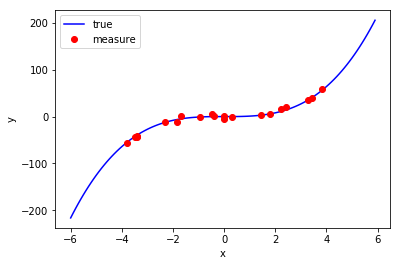

In [3]:
_x = np.arange(-6, 6, 0.1)
_y = map(lambda x: x*x*x, _x)
plt.plot(_x, _y, 'b-', label='true')
plt.plot(x_data, y_data, 'ro', label='measure')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
def normalize_data(x):
    mu = np.mean(x)
    std = np.std(x)
    return (x-mu)/std, mu, std

In [15]:
x_data_norm, x_mu, x_std = normalize_data(x_data)
y_data_norm, y_mu, y_std = normalize_data(y_data)

In [16]:
dataset = tf.data.Dataset.from_tensor_slices({
    'x': np.array(x_data_norm).astype(np.float32),
    'y': np.array(y_data_norm).astype(np.float32)
})
dataset = dataset.shuffle(20).batch(5)

## Regression Model

In [17]:
tf.keras.backend.set_floatx('float32')

In [18]:
def gaussian_nll(mean_values, var_values, y):
    y_diff = tf.math.subtract(y, mean_values)
    return 0.5*tf.reduce_mean(tf.math.log(var_values)) \
            + 0.5*tf.reduce_mean(tf.divide(tf.square(y_diff), var_values)) \
            + 0.5*tf.math.log(2*np.pi)

In [19]:
x_input = tfkl.Input(shape=[1,])
dense1 = tfkl.Dense(50, tf.nn.relu)(x_input)
dense2 = tfkl.Dense(50, activation=tf.nn.relu)(dense1)
out = tfkl.Dense(2)(dense2)

mean, raw_var = tf.split(out, num_or_size_splits=2, axis=1)

var = tf.math.log(1.0 + tf.exp(raw_var)) + 1e-6

model = tf.keras.Model(inputs=x_input, outputs=[mean, var])

In [20]:
for data in dataset:
    x, y = data['x'], data['y']
    x = tf.expand_dims(x, 1)
    y = tf.expand_dims(y, 1)

In [21]:
model(x)

[<tf.Tensor: id=423737, shape=(5, 1), dtype=float32, numpy=
 array([[-0.02779522],
        [ 0.23481771],
        [-0.00213668],
        [ 0.02422921],
        [-0.02271875]], dtype=float32)>,
 <tf.Tensor: id=423764, shape=(5, 1), dtype=float32, numpy=
 array([[0.7662887 ],
        [0.83055437],
        [0.69859374],
        [0.7065575 ],
        [0.75255877]], dtype=float32)>]

In [22]:
def grad(model, inputs, outputs):
    with tf.GradientTape() as t:
        mean_values, var_values = model(inputs)
        current_loss = gaussian_nll(mean_values, var_values, outputs)
    grads = t.gradient(current_loss, model.trainable_variables)
    
    return current_loss, grads

In [23]:
EPOCHS = 1000
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
for epoch in range(1, EPOCHS+1):
    for data in dataset:
        x, y = data['x'], data['y']
        x = tf.expand_dims(x, 1)
        y = tf.expand_dims(y, 1)
    
        with tf.GradientTape() as t:
            t.watch(x)
            loss_val, grads = grad(model, x, y)
        xgrad = t.gradient(loss_val, x)
    #     print(xgrad)
        x_p = x + 0.04 * tf.sign(xgrad)
        _, grads_adversarial = grad(model, x_p, y)

        alpha = 0.5
#         grads = grads + [alpha*_g for _g in grads_adversarial]
        
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 10 == 0:
#         m, v = model.predict(x)
#         print('err={}, var={}'.format(m-y, v))
        print('[{}/{}] loss = {:5f}'.format(epoch, EPOCHS, loss_val))

err=[[-0.12594472]
 [-0.45105708]
 [-0.0195303 ]
 [ 0.26934966]
 [-0.24550845]], var=[[0.6645884 ]
 [0.69478726]
 [0.60000175]
 [0.63972247]
 [0.677612  ]]
[10/1000] loss = 0.766075
err=[[-0.1533618 ]
 [ 0.31711107]
 [ 0.22747402]
 [-0.41401154]
 [ 0.5475444 ]], var=[[0.321349  ]
 [0.39025563]
 [0.5229709 ]
 [0.49087843]
 [0.41914937]]
[20/1000] loss = 0.656315
err=[[ 0.03561601]
 [-0.6525359 ]
 [-0.557549  ]
 [ 0.11674678]
 [ 0.03373289]], var=[[0.4348021 ]
 [0.34295854]
 [0.15277463]
 [0.22329412]
 [0.18031567]]
[30/1000] loss = 0.651762
err=[[-0.01525652]
 [-0.49400938]
 [-0.1988592 ]
 [-0.01250105]
 [ 0.02448702]], var=[[0.11696516]
 [0.10154469]
 [0.33001658]
 [0.3392819 ]
 [0.09551269]]
[40/1000] loss = 0.392364
err=[[ 0.23192441]
 [ 0.023471  ]
 [ 0.34810364]
 [-0.1271563 ]
 [ 0.02378619]], var=[[0.14549933]
 [0.05238417]
 [0.15665479]
 [0.2181988 ]
 [0.27343717]]
[50/1000] loss = 0.125308
err=[[ 0.05204237]
 [-0.37473392]
 [ 0.3113502 ]
 [ 0.08667183]
 [-0.11453124]], var=[[0.0

err=[[ 0.19229877]
 [-0.02733982]
 [-0.10147154]
 [-0.01561213]
 [ 0.02003423]], var=[[0.01502907]
 [0.00894021]
 [0.01349572]
 [0.00737946]
 [0.0099853 ]]
[460/1000] loss = -0.954971
err=[[ 0.03026715]
 [ 0.09152937]
 [ 0.0466249 ]
 [ 0.00796294]
 [-0.03244573]], var=[[0.00960677]
 [0.0153717 ]
 [0.00917834]
 [0.00906205]
 [0.00648282]]
[470/1000] loss = -1.037255
err=[[-0.07168645]
 [ 0.13371027]
 [-0.15184093]
 [ 0.03506893]
 [-0.09748587]], var=[[0.01276193]
 [0.019902  ]
 [0.02226671]
 [0.00939449]
 [0.00992572]]
[480/1000] loss = -0.457268
err=[[-0.01205836]
 [-0.01101879]
 [ 0.14075375]
 [-0.08231378]
 [-0.09144577]], var=[[0.00474218]
 [0.00688055]
 [0.01633879]
 [0.00786249]
 [0.01022104]]
[490/1000] loss = -0.803507
err=[[-0.01950239]
 [-0.0240777 ]
 [ 0.01839018]
 [ 0.02829412]
 [-0.00898147]], var=[[0.00685096]
 [0.00471314]
 [0.0072209 ]
 [0.00441307]
 [0.00658363]]
[500/1000] loss = -1.472321
err=[[-0.01018398]
 [ 0.01098603]
 [-0.06457368]
 [-0.0811553 ]
 [ 0.03804987]],

err=[[ 0.01918925]
 [-0.10801125]
 [ 0.04951304]
 [-0.0912364 ]
 [ 0.15666533]], var=[[0.00155807]
 [0.02441456]
 [0.00250625]
 [0.01732846]
 [0.01546586]]
[910/1000] loss = -1.111265
err=[[-0.07583927]
 [-0.11501014]
 [-0.00644767]
 [-0.09527913]
 [ 0.07608867]], var=[[0.01686394]
 [0.02309415]
 [0.00474806]
 [0.00612217]
 [0.00352867]]
[920/1000] loss = -0.900986
err=[[ 0.00709565]
 [ 0.0577057 ]
 [-0.00117958]
 [-0.05556765]
 [ 0.14038432]], var=[[0.00103415]
 [0.00767026]
 [0.00507586]
 [0.00827427]
 [0.00600256]]
[930/1000] loss = -1.171842
err=[[ 0.11224854]
 [ 0.0052986 ]
 [ 0.01301712]
 [-0.00451744]
 [-0.15859163]], var=[[0.01362061]
 [0.00148713]
 [0.00221984]
 [0.00484263]
 [0.0218627 ]]
[940/1000] loss = -1.418518
err=[[ 0.00341618]
 [-0.075216  ]
 [ 0.12801409]
 [-0.08375281]
 [ 0.03675473]], var=[[0.00346692]
 [0.00886687]
 [0.00644583]
 [0.013671  ]
 [0.01563344]]
[950/1000] loss = -1.001771
err=[[-0.04772702]
 [-0.05033898]
 [-0.06460822]
 [-0.03349331]
 [ 0.0241432 ]],

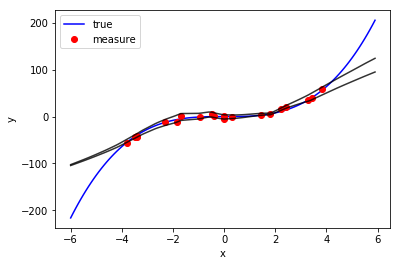

In [26]:
_x = np.arange(-6, 6, 0.1)
_y = map(lambda x: x*x*x, _x)

plt.plot(_x, _y, 'b-', label='true')
plt.plot(x_data, y_data, 'ro', label='measure')

mu, var = model.predict((_x - x_mu)/x_std)
upper_y = (mu + 2*np.sqrt(var))*y_std + y_mu
lower_y = (mu - 2*np.sqrt(var))*y_std + y_mu

plt.plot(_x, upper_y, 'k-', alpha=0.8)
plt.plot(_x, lower_y, 'k-', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()